In [74]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from eval_util import make_compare_plot,plot_cdf,plot_pdf,make_prediction_diff,make_prediction,DCR, hitting_rate, make_clustering,convert_type
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
import numpy
from tqdm import tqdm
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
import os
import glob
%matplotlib inline

In [4]:
def plot_pdf(data,label,bin=10):
    count, bins_count = np.histogram(data, bins=10)
    pdf = count / sum(count)

    plt.plot(bins_count[1:], pdf, label=label)

def plot_cdf(data,label,bin=10):
    count, bins_count = np.histogram(data, bins=10)
    pdf = count / sum(count)
    cdf = np.cumsum(pdf)
    plt.plot(bins_count[1:], cdf, label=label)

def make_compare_plot(datasets,col_name, function, names, title, dataset, additional=""):
    for i in range(len(datasets)):
        data = datasets[i]
        function(data[col_name],names[i])
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.savefig("evaluation_result/{}/{}_{}.png".format(dataset,title,additional))
    plt.show()


In [75]:
dataname = "ticket"
datapath = "dataset"
generated = "{}/generated/{}/".format(datapath,dataname)


data_origin = pd.read_csv("{}/origin/{}.csv".format(datapath,dataname))

#datalist = ["ctgan","tablegan","octgan","VAE","KL_daisy","sel_daisy","sm_daisy","selgan"]


ctgan = pd.read_csv("{}/generated/{}/ctgan/ctgan_less_300.csv".format(datapath,dataname))

if (dataname =="adult") or  (dataname =="credit"):
    tablegan = pd.read_csv("{}/generated/{}/tablegan/tablegan_{}_fake.csv".format(datapath,dataname,dataname))

if not dataname == "ticket":
    octgan = pd.read_csv("{}/generated/{}/octgan/octgan_{}_less.csv".format(datapath,dataname,dataname))
    
VAE = pd.read_csv("{}/generated/{}/VAE/sample_data_vae_800_0.csv".format(datapath,dataname,dataname)).set_axis(data_origin.columns, axis=1, inplace=False)
#VAE = pd.read_csv("{}/generated/{}/ctgan/tvae_200.csv".format(datapath,dataname))


selgan = pd.read_csv("{}/generated/{}/selgan/selgan_300_full_batch.csv".format(datapath,dataname))


KL_daisy = pd.read_csv("{}/generated/{}/KL/KL_1_800_0.csv".format(datapath,dataname,dataname))
sel_daisy = pd.read_csv("{}/generated/{}/sel/sel_1_800_0.csv".format(datapath,dataname,dataname))
sm_daisy = pd.read_csv("{}/generated/{}/sel_mean/sel_mean_1_800_0.csv".format(datapath,dataname,dataname))


In [6]:
save_path = "evaluation_result/{}".format(dataname)
try:
    os.mkdir(save_path)
except:
    pass

In [8]:
def mode_collapse(datalist,namelist):
    for i in range(len(datalist)):
        data = datalist[i]
        name = namelist[i]
        print(name, (data.shape[0] - data.drop_duplicates().shape[0])/(data.shape[0])*100)

mode_collapse([ctgan,selgan,VAE],["ctgan","selgan","VAE"])

ctgan 0.0
selgan 0.0
VAE 9.78


In [9]:
selgan.columns

Index(['ItinID', 'MktID', 'MktCoupons', 'Year', 'Quarter', 'OriginAirportID',
       'OriginAirportSeqID', 'OriginCityMarketID', 'Origin', 'OriginCountry',
       'OriginStateFips', 'OriginState', 'OriginStateName', 'OriginWac',
       'DestAirportID', 'DestAirportSeqID', 'DestCityMarketID', 'Dest',
       'DestCountry', 'DestStateFips', 'DestState', 'DestStateName', 'DestWac',
       'AirportGroup', 'WacGroup', 'TkCarrierChange', 'TkCarrierGroup',
       'OpCarrierChange', 'OpCarrierGroup', 'RPCarrier', 'TkCarrier',
       'OpCarrier', 'BulkFare', 'Passengers', 'ItinGeoType', 'MktGeoType',
       'MktDistanceGroup', 'MktFare', 'MktDistance', 'MktMilesFlown',
       'NonStopMiles'],
      dtype='object')

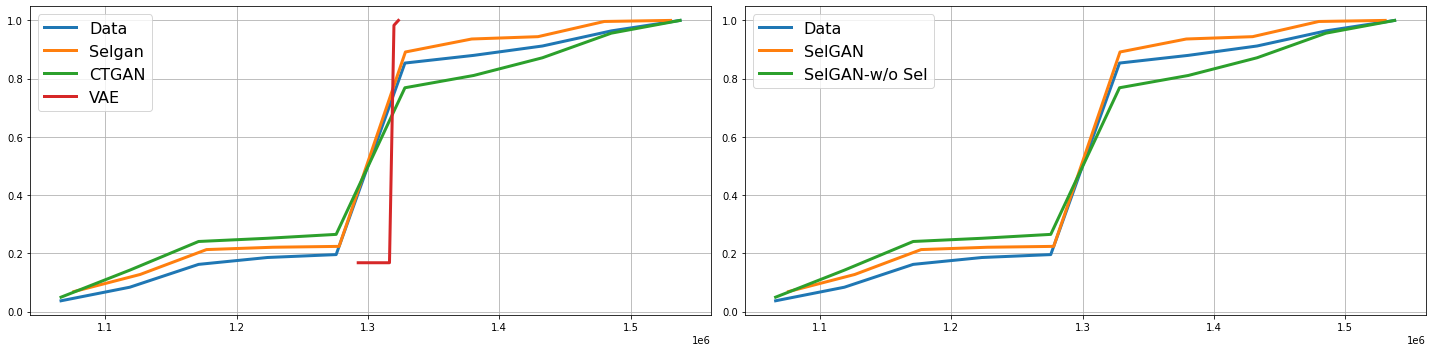

In [16]:
import matplotlib.font_manager as font_manager

column_name = "OriginAirportSeqID"
datasetleft = [data_origin, selgan, ctgan, VAE]
datanameleft = ["Data", "Selgan","CTGAN", "VAE"]
datasetright = [data_origin, selgan, ctgan]
datanameright = ["Data", "SelGAN", "SelGAN-w/o Sel"]

fig, (axs1,axs2) = plt.subplots(1,2, figsize = (20,5))

font = font_manager.FontProperties(
                                   #family='Comic Sans MS',
                                   #weight='bold',
                                   #style='normal', 
                                    size=16)


for i in range(len(datasetleft)):
    data = datasetleft[i][column_name]
    count, bins_count = np.histogram(data, bins=10)
    pdf = count / sum(count)
    cdf = np.cumsum(pdf)
    axs1.plot(bins_count[1:], cdf, label=datanameleft[i],linewidth=3)

for i in range(len(datasetright)):
    data = datasetright[i][column_name]
    count, bins_count = np.histogram(data, bins=10)
    pdf = count / sum(count)
    cdf = np.cumsum(pdf)
    axs2.plot(bins_count[1:], cdf, label=datanameright[i],linewidth=3)
    
axs1.legend(prop=font)
axs1.grid()
axs2.legend(prop=font)
axs2.grid()
fig.tight_layout()
        
    
# plt.subplots_adjust(left=0.1,
#                     bottom = 0.1, 
#                     right=0.9, 
#                     top=0.9, 
#                     wspace=0.2, 
#                     hspace=0.1)

plt.savefig("evaluation_result/{}/CDF_{}.png".format(dataname,column_name))

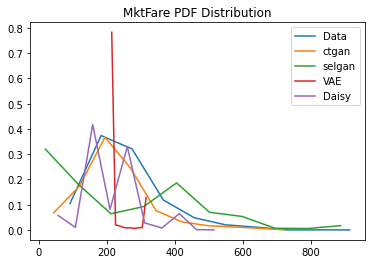

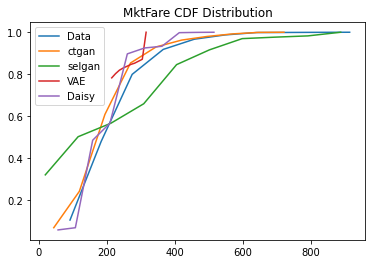

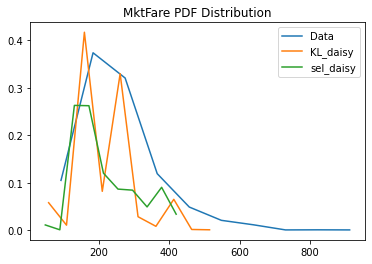

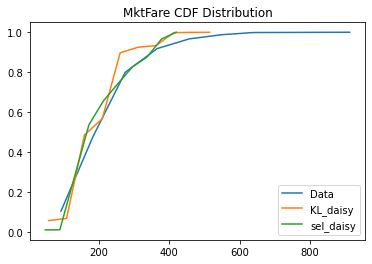

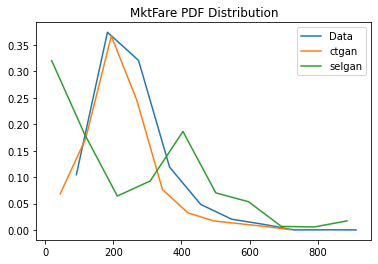

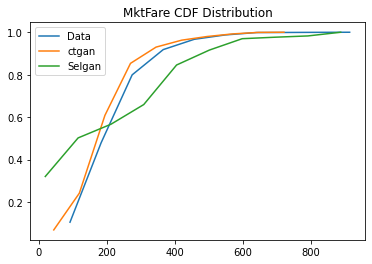

In [4]:
column_name = "MktFare"

make_compare_plot([data_origin,ctgan,selgan,VAE,KL_daisy],column_name,
plot_pdf,["Data", "ctgan","selgan","VAE","Daisy"],"{} PDF Distribution".format(column_name),dataname,"full",False)
make_compare_plot([data_origin,ctgan, selgan,VAE,KL_daisy],column_name,
plot_cdf,["Data", "ctgan","selgan","VAE","Daisy"],"{} CDF Distribution".format(column_name),dataname,"full",False)

make_compare_plot([data_origin, KL_daisy, sel_daisy],column_name,
plot_pdf,["Data", "KL_daisy", "sel_daisy"],"{} PDF Distribution".format(column_name),dataname,"Daisy",False)
make_compare_plot([data_origin, KL_daisy, sel_daisy],column_name,
plot_cdf,["Data", "KL_daisy", "sel_daisy"],"{} CDF Distribution".format(column_name),dataname,"Daisy",False)

make_compare_plot([data_origin, ctgan, selgan],column_name,
plot_pdf,["Data", "ctgan", "selgan"],"{} PDF Distribution".format(column_name),dataname,"selgan",False)
make_compare_plot([data_origin, ctgan, selgan],column_name,
plot_cdf,["Data", "ctgan", "Selgan"],"{} CDF Distribution".format(column_name),dataname,"selgan",False)

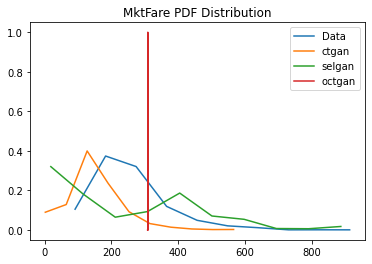

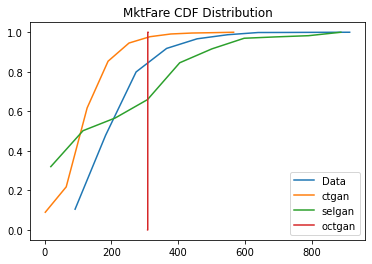

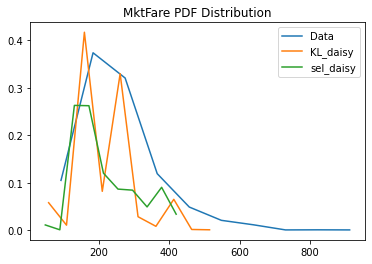

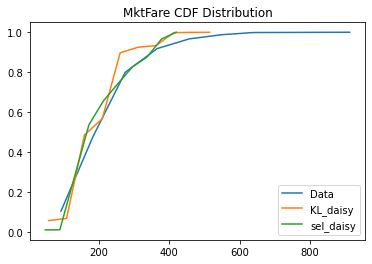

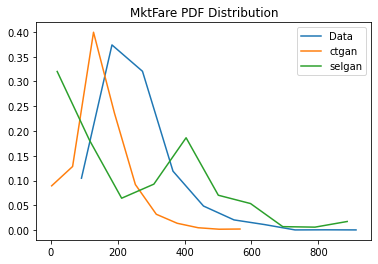

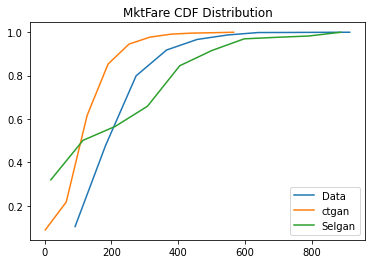

In [45]:
column_name = "MktFare"

make_compare_plot([data_origin,ctgan,selgan, octgan],column_name,
plot_pdf,["Data", "ctgan","selgan", "octgan"],"{} PDF Distribution".format(column_name),dataname,"full")
make_compare_plot([data_origin,ctgan, selgan, octgan],column_name,
plot_cdf,["Data", "ctgan","selgan", "octgan"],"{} CDF Distribution".format(column_name),dataname,"full")

make_compare_plot([data_origin, KL_daisy, sel_daisy],column_name,
plot_pdf,["Data", "KL_daisy", "sel_daisy"],"{} PDF Distribution".format(column_name),dataname,"Daisy")
make_compare_plot([data_origin, KL_daisy, sel_daisy],column_name,
plot_cdf,["Data", "KL_daisy", "sel_daisy"],"{} CDF Distribution".format(column_name),dataname,"Daisy")

make_compare_plot([data_origin, ctgan, selgan],column_name,
plot_pdf,["Data", "ctgan", "selgan"],"{} PDF Distribution".format(column_name),dataname,"selgan")
make_compare_plot([data_origin, ctgan, selgan],column_name,
plot_cdf,["Data", "ctgan", "Selgan"],"{} CDF Distribution".format(column_name),dataname,"selgan")

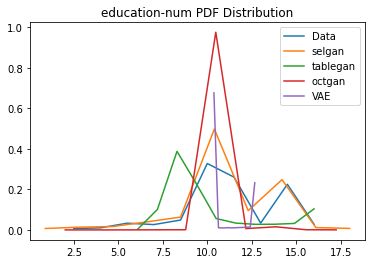

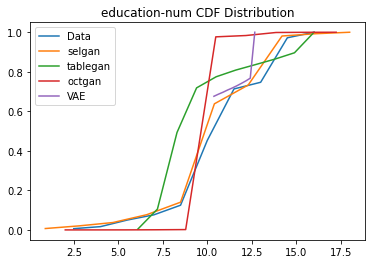

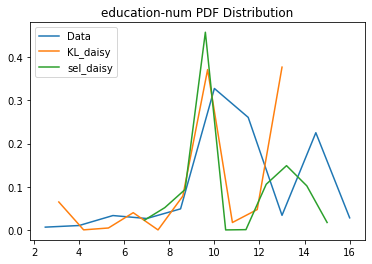

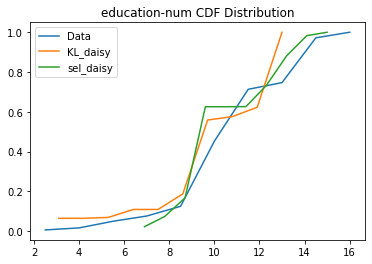

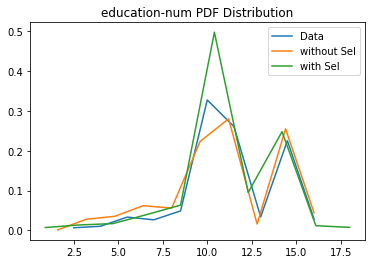

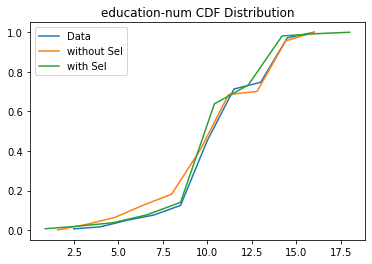

In [26]:
# CDF 可以用
column_name = "elevation"

make_compare_plot([data_origin, selgan, tablegan, octgan, VAE],column_name,
plot_pdf,["Data", "selgan", "tablegan", "octgan", "VAE"],"{} PDF Distribution".format(column_name),dataname,"full")
make_compare_plot([data_origin, selgan, tablegan, octgan, VAE],column_name,
plot_cdf,["Data", "selgan", "tablegan", "octgan", "VAE"],"{} CDF Distribution".format(column_name),dataname,"full")

make_compare_plot([data_origin, KL_daisy, sel_daisy],column_name,
plot_pdf,["Data", "KL_daisy", "sel_daisy"],"{} PDF Distribution".format(column_name),dataname,"Daisy")
make_compare_plot([data_origin, KL_daisy, sel_daisy],column_name,
plot_cdf,["Data", "KL_daisy", "sel_daisy"],"{} CDF Distribution".format(column_name),dataname,"Daisy")

make_compare_plot([data_origin, ctgan, selgan],column_name,
plot_pdf,["Data", "without Sel", "with Sel"],"{} PDF Distribution".format(column_name),dataname,"selgan")
make_compare_plot([data_origin, ctgan, selgan],column_name,
plot_cdf,["Data", "without Sel", "with Sel"],"{} CDF Distribution".format(column_name),dataname,"selgan")



In [48]:
data_origin.columns

Index(['ItinID', 'MktID', 'MktCoupons', 'Year', 'Quarter', 'OriginAirportID',
       'OriginAirportSeqID', 'OriginCityMarketID', 'Origin', 'OriginCountry',
       'OriginStateFips', 'OriginState', 'OriginStateName', 'OriginWac',
       'DestAirportID', 'DestAirportSeqID', 'DestCityMarketID', 'Dest',
       'DestCountry', 'DestStateFips', 'DestState', 'DestStateName', 'DestWac',
       'AirportGroup', 'WacGroup', 'TkCarrierChange', 'TkCarrierGroup',
       'OpCarrierChange', 'OpCarrierGroup', 'RPCarrier', 'TkCarrier',
       'OpCarrier', 'BulkFare', 'Passengers', 'ItinGeoType', 'MktGeoType',
       'MktDistanceGroup', 'MktFare', 'MktDistance', 'MktMilesFlown',
       'NonStopMiles'],
      dtype='object')

In [54]:
#Distance between NMI matrices
dataset = [data_origin,ctgan,selgan,octgan,VAE,KL_daisy,sel_daisy,sm_daisy]

distance_NMI = {}

from sklearn.metrics.cluster import normalized_mutual_info_score
for col in ['DestState','DestStateName', 'DestWac', 'AirportGroup']:
    
    mylist = []
    for data in dataset:
        A = data_origin[col].sample(n=1000, random_state=1)
        B = data[col].sample(n=1000, random_state=1)
        mylist.append(normalized_mutual_info_score(A,B))
    distance_NMI[col] = mylist
        

In [55]:
from sklearn.metrics.cluster import normalized_mutual_info_score
normalized_mutual_info_score([1,2,3,4,5], [5,4,3,2,1])



1.0

In [56]:
distance_NMI_df = pd.DataFrame(distance_NMI,index=["ground Truth",'ctgan','selgan','octgan','VAE','KL_daisy','sel_daisy','sm_daisy'])
distance_NMI_df.to_csv("evaluation_result/{}/distance_NMI.csv".format(dataname),index = False)

In [57]:
distance_NMI_df

,DestState,DestStateName,DestWac,AirportGroup
ground Truth,1.000000,1.000000,1.000000,1.000000
ctgan,0.128570,0.134669,0.128152,0.834273
selgan,0.092483,0.090073,0.095019,0.703696
octgan,0.000000,0.000000,0.000000,0.000000
VAE,0.026461,0.026461,0.026248,0.220233
KL_daisy,0.101009,0.109059,0.098108,0.710898
sel_daisy,0.090657,0.083233,0.102417,0.654479
sm_daisy,0.090215,0.077294,0.084481,0.687386


In [19]:
import scipy
import scipy.cluster.hierarchy as sch
import seaborn as sns

def cluster_corr(corr_array, inplace=False):
    """
    Rearranges the correlation matrix, corr_array, so that groups of highly 
    correlated variables are next to eachother 
    
    Parameters
    ----------
    corr_array : pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix 
        
    Returns
    -------
    pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix with the columns and rows rearranged
    """
    pairwise_distances = sch.distance.pdist(corr_array)
    linkage = sch.linkage(pairwise_distances, method='complete')
    cluster_distance_threshold = pairwise_distances.max()/2
    idx_to_cluster_array = sch.fcluster(linkage, cluster_distance_threshold, 
                                        criterion='distance')
    idx = np.argsort(idx_to_cluster_array)
    
    if not inplace:
        corr_array = corr_array.copy()
    
    if isinstance(corr_array, pd.DataFrame):
        return corr_array.iloc[idx, :].T.iloc[idx, :]
    return corr_array[idx, :][:, idx]

In [6]:
VAE = VAE.dropna()

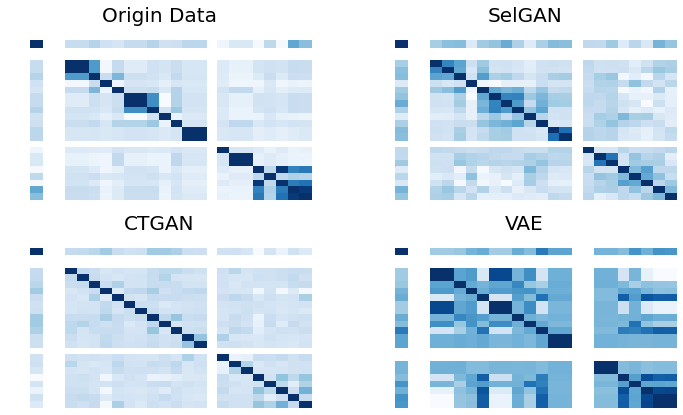

In [24]:
f,axs = plt.subplots(2,2,figsize = (12,7))

sns.heatmap(data_origin.corr(),cmap='Blues', yticklabels=False,xticklabels=False, cbar=False, ax = axs[0,0])
axs[0, 0].set_title('Origin Data', fontsize=20)

sns.heatmap((selgan.corr()),cmap='Blues', yticklabels=False,xticklabels=False, cbar=False, ax = axs[0,1])
axs[0, 1].set_title('SelGAN', fontsize=20)

sns.heatmap((ctgan.corr()),cmap='Blues', yticklabels=False,xticklabels=False, cbar=False, ax = axs[1,0])
axs[1, 0].set_title('CTGAN', fontsize=20)

# sns.heatmap((octgan.corr()),cmap='Blues', yticklabels=False,xticklabels=False, cbar=False, ax = axs[1,0])
# axs[1, 0].set_title('OCTGAN', fontsize=20)

# sns.heatmap((tablegan.corr()),cmap='Blues', yticklabels=False,xticklabels=False, cbar=False, ax = axs[1,1])
# axs[1, 1].set_title('tableGAN', fontsize=20)

sns.heatmap((VAE.corr()),cmap='Blues', yticklabels=False,xticklabels=False, cbar=False, ax = axs[1,1])
axs[1, 1].set_title('VAE', fontsize=20)

# axs[1][2].set_visible(False)

# axs[1][0].set_position([0.24,0.125,0.228,0.343])
# axs[1][1].set_position([0.55,0.125,0.228,0.343])

plt.savefig("evaluation_result/{}/CompleteHeatmap.png".format(dataname,"Origin Data"))
plt.show()

In [25]:
#print("octgan",abs(data_origin.corr() - octgan.corr()).sum().sum())
print("selgan",abs(data_origin.corr() - ctgan.corr()).sum().sum())
print("ctgan",abs(data_origin.corr() - selgan.corr()).sum().sum())
#
print("vae",abs(data_origin.corr() - VAE.corr()).sum().sum())


selgan 45.54842498995091
ctgan 59.597819810553545
vae 91.41312283402183


## Evaluation

#### Convert data type

In [ ]:
import json

with open(datapath +"/configeration/" +dataname+"_config.json", 'r') as f:
    config = json.load(f)

In [ ]:
categoricals = config["one-hot_cols"]
ordinals = config["ordinal_cols"]

#coverted_train = convert_type(train, categoricals+ordinals)

In [ ]:
ordinals

[]

In [ ]:
#sorted(categoricals+ordinals)

In [76]:
# tablegan没有income 所以不参加

data_origin["label"] = "data"


ctgan["label"] = "ctgan"
selgan["label"] = "selgan"
#octgan["label"] = "octgan"
#tablegan["label"] = "tablegan"
VAE["label"] = "VAE"
KL_daisy["label"] = "KL"
sel_daisy["label"] = "sel"
sm_daisy["label"] = "sm"



In [77]:
full = pd.concat([data_origin,ctgan,selgan,VAE,KL_daisy,sel_daisy,sm_daisy])
full = full[data_origin.columns]
full = convert_type(full,sorted(categoricals+ordinals))

my col_list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]


In [78]:

data_origin = full[full["label"] == "data"]
ctgan = full[full["label"] == "ctgan"]
selgan = full[full["label"] == "selgan"]
#octgan = full[full["label"] == "octgan"]
#tablegan = full[full["label"] == "tablegan"]
VAE = full[full["label"] == "VAE"]
KL_daisy = full[full["label"] == "KL"]
sel_daisy = full[full["label"] == "sel"]
sm_daisy = full[full["label"] == "sm"]




#### Split train and test

In [11]:
data_origin_droped = data_origin.drop(columns=["label"]).astype("float64")
origin_np = np.array(data_origin_droped)
col = list(data_origin_droped.columns)
indices = numpy.random.permutation(data_origin.shape[0])
n = int(data_origin.shape[0] * 0.3)
test_idx, training_idx = indices[:n], indices[n:]
training_data, test = pd.DataFrame(origin_np[training_idx,:],columns = col), pd.DataFrame(origin_np[test_idx,:],columns = col)
#training_data = training_data.drop(columns=["label","fnlwgt","income"]).astype("float64")

In [12]:
sm_daisy

,ItinID,MktID,MktCoupons,Year,Quarter,OriginAirportID,OriginAirportSeqID,OriginCityMarketID,Origin,OriginCountry,...,BulkFare,Passengers,ItinGeoType,MktGeoType,MktDistanceGroup,MktFare,MktDistance,MktMilesFlown,NonStopMiles,label
0,0,0,1,0,0,41,41,46,41,0,...,0,0,1,1,1,5.521562,755.0,2287.0,2080.0,sm
1,0,0,0,0,0,46,46,53,33,0,...,0,1,1,1,2,171.227481,1151.0,1676.0,1368.0,sm
2,0,0,0,0,0,46,46,53,33,0,...,0,1,1,1,2,171.029666,1622.0,1637.0,1381.0,sm
3,0,0,1,0,0,46,42,21,41,0,...,0,0,1,1,1,241.782069,910.0,871.0,642.0,sm
4,0,0,1,0,0,41,41,46,41,0,...,0,0,1,1,1,258.116444,771.0,2340.0,2047.0,sm
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4495,0,0,1,0,0,47,47,32,47,0,...,0,0,1,1,1,162.779857,898.0,699.0,1009.0,sm
4496,0,0,0,0,0,41,41,46,41,0,...,0,1,1,1,2,137.163568,1414.0,1114.0,936.0,sm
4497,0,0,0,0,0,41,41,46,47,0,...,0,0,1,1,2,123.975801,761.0,2166.0,2092.0,sm
4498,0,0,0,0,0,19,45,44,45,0,...,0,0,1,1,0,182.315508,468.0,614.0,412.0,sm


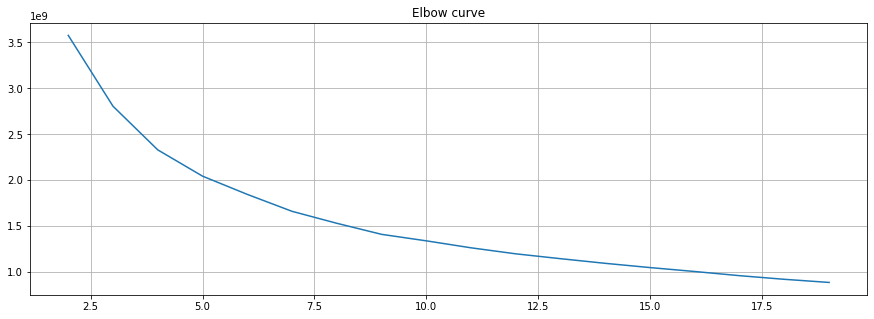

In [137]:

distorsions = []
for k in range(2, 20):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(data_origin_droped)
    distorsions.append(kmeans.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 20), distorsions)
plt.grid(True)

plt.title('Elbow curve')
plt.show()

In [79]:
from tqdm import tqdm
from sklearn.metrics import f1_score

def make_prediction(response, response_type,training_data, test, dataset, clf):

    f1 = []
    auc = []
    mse = []
    result = []

    train_data_y = training_data[response].astype("float64")
    train_data_X = training_data.drop(columns=[response]).astype("float64")

    test_data_X = test.drop(columns=[response]).astype("float64")
    test_data_y = test[response].astype("float64")


    clf.fit(train_data_X, train_data_y)
    pred_data_y = clf.predict(test_data_X)
    result.append(clf.score(test_data_X,test_data_y))
    
    
    if response_type == "clf":
        f1.append(f1_score(test_data_y, pred_data_y
                           ,average='weighted'))
        
    else:
        mse.append(((pred_data_y-test_data_y)**2).mean())


    for data in tqdm(dataset):

        train_X = data.drop(columns=[response,"label"]).astype("float64")
        train_y = data[response].astype("float64")
        
        #try:
        clf.fit(train_X, train_y)
        pred_data_y = clf.predict(test_data_X)
        #except:
        #    result.append(np.nan)
            
        if response_type == "clf":
            result.append(clf.score(test_data_X,test_data_y))
            f1.append(f1_score(test_data_y, pred_data_y
                               ,average='weighted'))      
            
        else:
            result.append(clf.score(test_data_X,test_data_y))
            mse.append(((pred_data_y-test_data_y)**2).mean())

    if response_type == "clf":       
        return result,f1
    else:
        return result,mse

In [18]:
# data_origin_droped = data_origin.astype("float64")
# origin_np = np.array(data_origin_droped)
# col = list(data_origin_droped.columns)
# indices = numpy.random.permutation(data_origin.shape[0])
# n = int(data_origin.shape[0] * 0.3)
# test_idx, training_idx = indices[:n], indices[n:]
# training_data, test = pd.DataFrame(origin_np[training_idx,:],columns = col), pd.DataFrame(origin_np[test_idx,:],columns = col)
# #training_data = training_data.drop(columns=["label","fnlwgt","income"]).astype("float64")

In [48]:
VAE

,ItinID,MktID,MktCoupons,Year,Quarter,OriginAirportID,OriginAirportSeqID,OriginCityMarketID,Origin,OriginCountry,...,BulkFare,Passengers,ItinGeoType,MktGeoType,MktDistanceGroup,MktFare,MktDistance,MktMilesFlown,NonStopMiles,label
0,0,0,0,0,0,46,46,32,46,0,...,0,0,1,1,1,202.66269,839.88727,1136.3052,1064.0573,VAE
1,0,0,0,0,0,46,46,53,46,0,...,0,0,1,1,1,202.66264,839.88776,1136.3052,1064.0573,VAE
2,0,0,0,0,0,46,46,53,46,0,...,0,0,1,1,0,202.66257,839.88727,1136.3053,1064.0573,VAE
3,0,0,0,0,0,46,46,53,46,0,...,0,0,1,1,1,202.66264,839.88794,1136.3052,1064.0573,VAE
4,0,0,1,0,0,41,41,46,41,0,...,0,0,1,1,2,202.66272,1314.08600,1716.8308,1607.1432,VAE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0,0,0,0,0,46,46,53,46,0,...,0,0,1,1,1,202.66309,839.88730,1136.3052,1064.0573,VAE
4996,0,0,1,0,0,41,41,46,41,0,...,0,0,1,1,3,202.66371,1314.08910,1716.8308,1607.1432,VAE
4997,0,0,1,0,0,46,46,32,46,0,...,0,0,1,1,0,284.53370,839.88750,1136.4393,1064.0692,VAE
4998,0,0,0,0,0,46,46,53,46,0,...,0,0,1,1,1,202.66273,839.88730,1136.3052,1064.0573,VAE


In [80]:
#dataset = [ctgan,selgan,octgan,tablegan,VAE,KL_daisy,sel_daisy,sm_daisy]
dataset = [ctgan,selgan,VAE]
dataset = [KL_daisy,KL_daisy,sm_daisy]
#dataset = [ctgan]

In [81]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.svm import LinearSVC
from sklearn.svm import LinearSVR

from sklearn.neural_network import MLPRegressor
from sklearn.neural_network import MLPClassifier


xgb_clf = xgb.XGBClassifier(eval_metric='mlogloss')
xgb_reg = xgb.XGBRegressor(eval_metric='mlogloss')

rf_clf = RandomForestClassifier(n_jobs = -1)
rf_reg = RandomForestRegressor(n_jobs = -1)

svm_clf = LinearSVC()
svm_reg = LinearSVR()

In [84]:
KL_daisy["MktCoupons"]

0       0
1       1
2       0
3       0
4       1
       ..
4495    0
4496    0
4497    1
4498    1
4499    1
Name: MktCoupons, Length: 4500, dtype: int8

In [87]:
ct_f1

,RF,SVM,avg
Origin,0.997637,0.881035,0.939336
KL_Daisy,0.875086,0.668580,0.771833
Sel-Daisy,0.882789,0.778063,0.830426
SM_Daisy,0.926046,0.512856,0.719451


In [85]:
#acc_xgb, f1_xgb = make_prediction("MktCoupons", "clf",training_data, test,dataset,xgb_clf)
acc_rf, f1_rf = make_prediction("MktCoupons", "clf",training_data, test,dataset,rf_clf)
acc_svm, f1_svm = make_prediction("MktCoupons", "clf",training_data, test,dataset,svm_clf)

100%|██████████| 3/3 [00:02<00:00,  1.10it/s]


In [86]:
ct_f1 = pd.DataFrame({"RF":f1_rf,"SVM":f1_svm},index = ["Origin","KL_Daisy","Sel-Daisy","SM_Daisy"])
ct_f1["avg"] = ct_f1.mean(axis=1)

In [25]:
#ct_f1 = pd.DataFrame({"XGB":f1_xgb,"RF":f1_rf,"SVM":f1_svm},index = ["Origin","CTGAN","Selgan","VAE"])
ct_f1["avg"] = ct_f1.mean(axis=1)

#ct_acc = pd.DataFrame({"XGB":acc_xgb,"RF":acc_rf,"SVM":acc_svm},index = ["Origin","CTGAN","Selgan","VAE"])
ct_acc["avg"] = ct_acc.mean(axis=1)

In [73]:
ct_f1.to_csv("t_mktcoupons_f1.csv")

In [41]:
ctgan.columns

Index(['ItinID', 'MktID', 'MktCoupons', 'Year', 'Quarter', 'OriginAirportID',
       'OriginAirportSeqID', 'OriginCityMarketID', 'Origin', 'OriginCountry',
       'OriginStateFips', 'OriginState', 'OriginStateName', 'OriginWac',
       'DestAirportID', 'DestAirportSeqID', 'DestCityMarketID', 'Dest',
       'DestCountry', 'DestStateFips', 'DestState', 'DestStateName', 'DestWac',
       'AirportGroup', 'WacGroup', 'TkCarrierChange', 'TkCarrierGroup',
       'OpCarrierChange', 'OpCarrierGroup', 'RPCarrier', 'TkCarrier',
       'OpCarrier', 'BulkFare', 'Passengers', 'ItinGeoType', 'MktGeoType',
       'MktDistanceGroup', 'MktFare', 'MktDistance', 'MktMilesFlown',
       'NonStopMiles', 'label'],
      dtype='object')

In [88]:
sp_r2_xgb, sp_mse_xgb = make_prediction("Passengers", "reg",training_data, test,dataset,xgb_reg)
sp_r2_rf, sp_mse_rf = make_prediction("Passengers", "reg",training_data, test,dataset,rf_reg)
sp_r2_svm, sp_mse_svm = make_prediction("Passengers", "reg",training_data, test,dataset,svm_reg)

100%|██████████| 3/3 [00:01<00:00,  1.51it/s]


In [90]:
sp = pd.DataFrame({"XGB":sp_mse_xgb,"RF":sp_mse_rf,"SVM":sp_mse_svm},index = ["Origin","KL_Daisy","Sel-Daisy","SM_Daisy"])
sp["avg"] = sp.mean(axis=1)
sp
#sp.to_csv("t_passengers_mse.csv")

,XGB,RF,SVM,avg
Origin,50.303314,44.958519,193.866770,96.376201
KL_Daisy,198.582516,172.116885,87.282996,152.660799
Sel-Daisy,198.582516,159.010171,70.912937,142.835208
SM_Daisy,99.398445,111.673487,103.550448,104.874127


In [57]:
prediction = {}
prediction["MktCoupons"] = make_prediction("MktCoupons", "clf",training_data, test, dataset)

prediction["OriginAirportID"] = make_prediction("OriginAirportID", "reg",training_data, test, dataset)
prediction["OriginCityMarketID"] = make_prediction("OriginCityMarketID", "reg",training_data, test, dataset)
prediction["Origin"] = make_prediction("Origin", "reg",training_data, test, dataset)
prediction["Origin_clf"] = make_prediction("Origin", "clf",training_data, test, dataset)


prediction["BulkFare"] = make_prediction("BulkFare", "reg",training_data, test, dataset)
prediction["Passengers"] = make_prediction("Passengers", "reg",training_data, test, dataset)
prediction["MktFare"] = make_prediction("MktFare", "reg",training_data, test, dataset)
prediction["MktDistance"] = make_prediction("MktDistance", "reg",training_data, test, dataset)
prediction["MktMilesFlown"] = make_prediction("MktMilesFlown", "reg",training_data, test, dataset)
prediction["NonStopMiles"] = make_prediction("NonStopMiles", "reg",training_data, test, dataset)

prediction["MktMilesFlown"] = make_prediction("MktMilesFlown", "reg",training_data, test, dataset)
prediction["NonStopMiles"] = make_prediction("NonStopMiles", "reg",training_data, test, dataset)
prediction["Dest"] = make_prediction("Dest", "reg",training_data, test, dataset)



TypeError: make_prediction() missing 1 required positional argument: 'clf'

In [37]:
make_prediction("NonStopMiles", "reg",training_data, test, dataset)

100%|██████████| 3/3 [00:01<00:00,  2.30it/s]


[7725.014691368789, 302022.8623885621, 302536.4277325182, 165230.24335748868]

In [100]:
# regression 效果一般

ML_result = pd.DataFrame(prediction,index=["ground Truth",'ctgan','selgan','VAE','KL_daisy','sel_daisy','sm_daisy'])

In [101]:
#ML_result[["workclass","relationship","sex"]]
ML_result

,MktCoupons,OriginAirportID,OriginCityMarketID,Origin,BulkFare,Passengers,MktFare,MktDistance,MktMilesFlown,NonStopMiles,Dest
ground Truth,0.998667,0.999999,0.998020,0.999999,0.0,-0.038881,-0.187939,0.992026,0.968113,0.971686,1.000000
ctgan,0.708667,0.010178,0.276009,-0.298947,0.0,-0.165489,-0.410302,-0.118360,-0.146111,0.001543,-0.105036
selgan,0.954667,-0.050770,0.161989,0.262562,0.0,-0.882860,-1.601969,-0.342775,-0.042624,-0.042835,0.041795
VAE,0.826000,0.221251,-0.699364,0.221251,0.0,-0.078841,-0.174154,0.343756,0.439525,0.424877,0.558127
KL_daisy,NaN,-0.207424,-0.080984,-0.151925,0.0,-3.027878,-0.252707,0.193538,0.647363,0.428942,-0.073860
sel_daisy,0.743333,-0.256066,-0.186416,-1.004104,0.0,-1.363012,-0.248722,0.207701,0.257843,0.124966,-0.040282
sm_daisy,0.862000,0.269015,-0.028893,0.097296,0.0,-1.102853,-0.166794,0.346862,0.566623,0.116685,-0.596849


In [145]:
training_data.columns

Index(['ItinID', 'MktID', 'MktCoupons', 'Year', 'Quarter', 'OriginAirportID',
       'OriginAirportSeqID', 'OriginCityMarketID', 'Origin', 'OriginCountry',
       'OriginStateFips', 'OriginState', 'OriginStateName', 'OriginWac',
       'DestAirportID', 'DestAirportSeqID', 'DestCityMarketID', 'Dest',
       'DestCountry', 'DestStateFips', 'DestState', 'DestStateName', 'DestWac',
       'AirportGroup', 'WacGroup', 'TkCarrierChange', 'TkCarrierGroup',
       'OpCarrierChange', 'OpCarrierGroup', 'RPCarrier', 'TkCarrier',
       'OpCarrier', 'BulkFare', 'Passengers', 'ItinGeoType', 'MktGeoType',
       'MktDistanceGroup', 'MktFare', 'MktDistance', 'MktMilesFlown',
       'NonStopMiles'],
      dtype='object')

In [181]:
training_data["OpCarrier"].value_counts()

2.0    3464
1.0      34
0.0       2
Name: OpCarrier, dtype: int64

In [182]:
prediction["OriginAirportID"] = make_prediction("OriginAirportID", "clf",training_data, test, dataset)
prediction["OriginCityMarketID"] = make_prediction("OriginCityMarketID", "clf",training_data, test, dataset)
prediction["OriginStateName"] = make_prediction("OriginStateName", "clf",training_data, test, dataset)
prediction["DestAirportID"] = make_prediction("DestAirportID", "clf",training_data, test, dataset)
prediction["DestStateFips"] = make_prediction("DestStateFips", "clf",training_data, test, dataset)



prediction["AirportGroup"] = make_prediction("AirportGroup", "reg",training_data, test, dataset)
prediction["WacGroup"] = make_prediction("WacGroup", "reg",training_data, test, dataset)

prediction["TkCarrierChange"] = make_prediction("TkCarrierChange", "clf",training_data, test, dataset)
prediction["TkCarrierGroup"] = make_prediction("TkCarrierGroup", "clf",training_data, test, dataset)

prediction["OpCarrierChange"] = make_prediction("OpCarrierChange", "clf",training_data, test, dataset)
prediction["OpCarrierGroup"] = make_prediction("OpCarrierGroup", "clf",training_data, test, dataset)


100%|██████████| 6/6 [00:06<00:00,  1.16s/it]


In [183]:
pd.DataFrame(prediction,index=["ground Truth",'ctgan','selgan','VAE','KL_daisy','sel_daisy','sm_daisy'])

,MktCoupons,OriginAirportID,OriginCityMarketID,Origin,BulkFare,Passengers,MktFare,MktDistance,MktMilesFlown,NonStopMiles,Dest,OriginStateName,DestAirportID,DestStateFips,AirportGroup,WacGroup,TkCarrierChange,TkCarrierGroup,OpCarrierChange,OpCarrierGroup
ground Truth,0.998667,0.992000,0.988000,0.999999,0.0,-0.038881,-0.187939,0.992026,0.968113,0.971686,1.000000,0.999333,0.998667,1.000000,0.999700,0.999495,1.000000,0.998667,1.000000,0.998667
ctgan,0.708667,0.590000,0.546667,-0.298947,0.0,-0.165489,-0.410302,-0.118360,-0.146111,0.001543,-0.105036,0.668667,0.392000,0.632000,-0.173196,0.184537,0.990000,0.690000,0.988000,0.699333
selgan,0.954667,0.578000,0.564000,0.262562,0.0,-0.882860,-1.601969,-0.342775,-0.042624,-0.042835,0.041795,0.724000,0.418000,0.586667,0.121999,-0.027842,0.997333,0.936000,0.998000,0.968667
VAE,0.826000,0.517333,0.340000,0.221251,0.0,-0.078841,-0.174154,0.343756,0.439525,0.424877,0.558127,0.680000,0.304000,0.630000,-0.530596,-1.413791,0.999333,0.986667,0.999333,0.986667
KL_daisy,NaN,0.400000,0.381333,-0.151925,0.0,-3.027878,-0.252707,0.193538,0.647363,0.428942,-0.073860,0.478000,0.324000,0.432000,-0.357703,-0.425326,1.000000,0.901333,0.990000,0.901333
sel_daisy,0.743333,0.410667,0.453333,-1.004104,0.0,-1.363012,-0.248722,0.207701,0.257843,0.124966,-0.040282,0.595333,0.198000,0.337333,-0.455478,-0.402936,0.990000,0.910000,0.990000,0.787333
sm_daisy,0.862000,0.513333,0.434000,0.097296,0.0,-1.102853,-0.166794,0.346862,0.566623,0.116685,-0.596849,0.448000,0.205333,0.481333,-0.030683,-0.167369,0.994667,0.852000,1.000000,0.892667


In [122]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
def make_prediction_rf(response, response_type,training_data, test, dataset):

    result = []

    train_data_y = training_data[response].astype("float64")
    train_data_X = training_data.drop(columns=[response]).astype("float64")

    test_data_X = test.drop(columns=[response]).astype("float64")
    test_data_y = test[response].astype("float64")


    if response_type == "clf":

        #clf = xgb.XGBClassifier(eval_metric='mlogloss')
        clf = RandomForestClassifier(random_state=0)

    else:

        clf = RandomForestRegressor(random_state=0)

    clf.fit(train_data_X, train_data_y)
    result.append(clf.score(test_data_X,test_data_y))


    for data in tqdm(dataset):

        train_X = data.drop(columns=[response,"label"]).astype("float64")
        train_y = data[response].astype("float64")
        
        try:
            clf.fit(train_X, train_y)
            result.append(clf.score(test_data_X,test_data_y))
        except:
            result.append(np.nan)

    return result

In [123]:
prediction_rf = {}
prediction_rf["MktCoupons"] = make_prediction_rf("MktCoupons", "clf",training_data, test, dataset)

prediction_rf["OriginAirportID"] = make_prediction_rf("OriginAirportID", "reg",training_data, test, dataset)
prediction_rf["OriginCityMarketID"] = make_prediction_rf("OriginCityMarketID", "reg",training_data, test, dataset)
prediction_rf["Origin"] = make_prediction_rf("Origin", "reg",training_data, test, dataset)


prediction_rf["BulkFare"] = make_prediction_rf("BulkFare", "reg",training_data, test, dataset)
prediction_rf["Passengers"] = make_prediction_rf("Passengers", "reg",training_data, test, dataset)
prediction_rf["MktFare"] = make_prediction_rf("MktFare", "reg",training_data, test, dataset)
prediction_rf["MktDistance"] = make_prediction_rf("MktDistance", "reg",training_data, test, dataset)
prediction_rf["MktMilesFlown"] = make_prediction_rf("MktMilesFlown", "reg",training_data, test, dataset)
prediction_rf["NonStopMiles"] = make_prediction_rf("NonStopMiles", "reg",training_data, test, dataset)

prediction_rf["MktMilesFlown"] = make_prediction_rf("MktMilesFlown", "reg",training_data, test, dataset)
prediction_rf["NonStopMiles"] = make_prediction_rf("NonStopMiles", "reg",training_data, test, dataset)
prediction_rf["Dest"] = make_prediction_rf("Dest", "reg",training_data, test, dataset)


100%|██████████| 6/6 [00:16<00:00,  2.80s/it]


In [125]:
prediction_rf["Origin"] = make_prediction_rf("Origin", "clf",training_data, test, dataset)

100%|██████████| 6/6 [00:04<00:00,  1.32it/s]


In [127]:
ML_result_ref = pd.DataFrame(prediction_rf,index=["ground Truth",'ctgan','selgan','VAE','KL_daisy','sel_daisy','sm_daisy'])
ML_result_ref


,MktCoupons,OriginAirportID,OriginCityMarketID,Origin,BulkFare,Passengers,MktFare,MktDistance,MktMilesFlown,NonStopMiles,Dest
ground Truth,0.997333,0.999989,0.996786,0.994667,1.0,-0.007567,-0.141453,0.992216,0.961712,0.966137,0.999999
ctgan,0.711333,0.103804,0.340603,0.544000,1.0,-0.112144,-0.287880,-0.052246,-0.068741,0.159781,0.011074
selgan,0.964000,0.432291,0.316794,0.552667,1.0,-0.372755,-1.009070,-0.023509,0.232623,0.285155,0.155599
VAE,0.871333,0.221255,-0.381709,0.511333,1.0,-0.078841,-0.131745,0.248563,0.434810,0.436683,0.557369
KL_daisy,0.904667,-0.135975,0.192050,0.473333,1.0,-2.385375,-0.218992,0.321195,0.576759,0.721047,0.027567
sel_daisy,0.762000,-0.159075,0.131845,0.500667,1.0,-1.695212,-0.173911,0.249173,0.514579,0.372372,-0.013698
sm_daisy,0.932667,0.271090,0.170457,0.383333,1.0,-1.180292,-0.144090,0.451826,0.667636,0.477643,-0.067832


In [134]:
def make_clustering(training_data,test,dataset,n = 3):
    NMI = []

    train_data_x = training_data.drop(columns=[]).astype("float64")

    test_data_X = test.drop(columns=[]).astype("float64")
    
    kmeans = KMeans(n_clusters=n, random_state=0).fit(train_data_x)

    ground_truth = kmeans.predict(test_data_X)

    NMI.append(normalized_mutual_info_score(ground_truth, ground_truth))
    #print(train_data_x.columns)

    for data in dataset:
        data = data.drop(columns=["label"]).astype("float64")
        #print(data.columns)
        kmeans = KMeans(n_clusters=n, random_state=0).fit(data)
        result = kmeans.predict(test_data_X)
        NMI.append(normalized_mutual_info_score(ground_truth, result))




    return NMI
### Clustering

In [135]:
## Unsupervised Machine learning task 

from sklearn.cluster import KMeans
from sklearn.metrics.cluster import normalized_mutual_info_score
pd.DataFrame(make_clustering(training_data,test,dataset),index=["ground Truth",'ctgan','selgan','VAE','KL_daisy','sel_daisy','sm_daisy'],columns=["Clustering NMI"])

,Clustering NMI
ground Truth,1.000000
ctgan,0.393793
selgan,0.470033
VAE,0.357237
KL_daisy,0.368331
sel_daisy,0.465918
sm_daisy,0.410029


## Loss 

In [ ]:
data_log = pd.read_csv("dataset/generated/strong_cate/full/train_log.txt",
names=["epoch","time","G_origin","G_mean","G_fd","G_KL","G_sel"])
data_log["G_total"] = data_log["G_origin"] + data_log["G_mean"] + data_log["G_fd"] + data_log["G_KL"] + data_log["G_sel"]

fig, axs = plt.subplots(3,2,figsize = (9,6))
fig.suptitle('strong_cate_full training log')

axs[0][0].plot(data_log["G_total"])
axs[0][0].set_title("G_total")
axs[0][1].plot(data_log["G_origin"])
axs[0][1].set_title("G_origin")

axs[1][0].plot(data_log["G_mean"])
axs[1][0].set_title("G_mean")
axs[1][1].plot(data_log["G_KL"])
axs[1][1].set_title("G_KL")

axs[2][0].plot(data_log["G_fd"])
axs[2][0].set_title("G_fd")
axs[2][1].plot(data_log["G_sel"])
axs[2][1].set_title("G_sel")

for ax in axs.flat:
    ax.set(xlabel='times', ylabel='loss')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
plt.show()

In [ ]:
data_log = pd.read_csv("dataset/generated/weak_cate/full/train_log.txt",
names=["epoch","time","G_origin","G_mean","G_fd","G_KL","G_sel"])
data_log["G_total"] = data_log["G_origin"] + data_log["G_mean"] + data_log["G_fd"] + data_log["G_KL"] + data_log["G_sel"]

fig, axs = plt.subplots(3,2,figsize = (9,6))
fig.suptitle('weak_cate_full training log')

axs[0][0].plot(data_log["G_total"])
axs[0][0].set_title("G_total")
axs[0][1].plot(data_log["G_origin"])
axs[0][1].set_title("G_origin")

axs[1][0].plot(data_log["G_mean"])
axs[1][0].set_title("G_mean")
axs[1][1].plot(data_log["G_KL"])
axs[1][1].set_title("G_KL")

axs[2][0].plot(data_log["G_fd"])
axs[2][0].set_title("G_fd")
axs[2][1].plot(data_log["G_sel"])
axs[2][1].set_title("G_sel")

for ax in axs.flat:
    ax.set(xlabel='times', ylabel='loss')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
plt.show()

In [ ]:
data_log = pd.read_csv("dataset/generated/weak_num/full/train_log.txt",
names=["epoch","time","G_origin","G_mean","G_fd","G_KL","G_sel"])
data_log["G_total"] = data_log["G_origin"] + data_log["G_mean"] + data_log["G_fd"] + data_log["G_KL"] + data_log["G_sel"]

fig, axs = plt.subplots(3,2,figsize = (9,6))
fig.suptitle('weak_num_full training log')

axs[0][0].plot(data_log["G_total"])
axs[0][0].set_title("G_total")
axs[0][1].plot(data_log["G_origin"])
axs[0][1].set_title("G_origin")

axs[1][0].plot(data_log["G_mean"])
axs[1][0].set_title("G_mean")
axs[1][1].plot(data_log["G_KL"])
axs[1][1].set_title("G_KL")

axs[2][0].plot(data_log["G_fd"])
axs[2][0].set_title("G_fd")
axs[2][1].plot(data_log["G_sel"])
axs[2][1].set_title("G_sel")

for ax in axs.flat:
    ax.set(xlabel='times', ylabel='loss')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
plt.show()

In [ ]:
data_log = pd.read_csv("dataset/generated/strong_num/full/train_log.txt",
names=["epoch","time","G_origin","G_mean","G_fd","G_KL","G_sel"])
data_log["G_total"] = data_log["G_origin"] + data_log["G_mean"] + data_log["G_fd"] + data_log["G_KL"] + data_log["G_sel"]

fig, axs = plt.subplots(3,2,figsize = (9,6))
fig.suptitle('strong_num_full training log')

axs[0][0].plot(data_log["G_total"])
axs[0][0].set_title("G_total")
axs[0][1].plot(data_log["G_origin"])
axs[0][1].set_title("G_origin")

axs[1][0].plot(data_log["G_mean"])
axs[1][0].set_title("G_mean")
axs[1][1].plot(data_log["G_KL"])
axs[1][1].set_title("G_KL")

axs[2][0].plot(data_log["G_fd"])
axs[2][0].set_title("G_fd")
axs[2][1].plot(data_log["G_sel"])
axs[2][1].set_title("G_sel")

for ax in axs.flat:
    ax.set(xlabel='times', ylabel='loss')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
plt.show()

In [ ]:
data_log = pd.read_csv("dataset/generated/strong_cate/its/train_log.txt",
names=["epoch","time","G_origin","G_mean","G_fd","G_KL","G_sel"])
data_log["G_total"] = data_log["G_origin"] + data_log["G_mean"] + data_log["G_fd"] + data_log["G_KL"] + data_log["G_sel"]

fig, axs = plt.subplots(3,2,figsize = (9,6))
fig.suptitle('strong_cate_its training log')

axs[0][0].plot(data_log["G_total"])
axs[0][0].set_title("G_total")
axs[0][1].plot(data_log["G_origin"])
axs[0][1].set_title("G_origin")

axs[1][0].plot(data_log["G_mean"])
axs[1][0].set_title("G_mean")
axs[1][1].plot(data_log["G_KL"])
axs[1][1].set_title("G_KL")

axs[2][0].plot(data_log["G_fd"])
axs[2][0].set_title("G_fd")
axs[2][1].plot(data_log["G_sel"])
axs[2][1].set_title("G_sel")

for ax in axs.flat:
    ax.set(xlabel='times', ylabel='loss')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
plt.show()

In [ ]:
data_log = pd.read_csv("dataset/generated/weak_cate/its/train_log.txt",
names=["epoch","time","G_origin","G_mean","G_fd","G_KL","G_sel"])
data_log["G_total"] = data_log["G_origin"] + data_log["G_mean"] + data_log["G_fd"] + data_log["G_KL"] + data_log["G_sel"]

fig, axs = plt.subplots(3,2,figsize = (9,6))
fig.suptitle('weak_cate_its training log')

axs[0][0].plot(data_log["G_total"])
axs[0][0].set_title("G_total")
axs[0][1].plot(data_log["G_origin"])
axs[0][1].set_title("G_origin")

axs[1][0].plot(data_log["G_mean"])
axs[1][0].set_title("G_mean")
axs[1][1].plot(data_log["G_KL"])
axs[1][1].set_title("G_KL")

axs[2][0].plot(data_log["G_fd"])
axs[2][0].set_title("G_fd")
axs[2][1].plot(data_log["G_sel"])
axs[2][1].set_title("G_sel")

for ax in axs.flat:
    ax.set(xlabel='times', ylabel='loss')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
plt.show()

In [ ]:
data_log = pd.read_csv("dataset/generated/weak_num/its/train_log.txt",
names=["epoch","time","G_origin","G_mean","G_fd","G_KL","G_sel"])
data_log["G_total"] = data_log["G_origin"] + data_log["G_mean"] + data_log["G_fd"] + data_log["G_KL"] + data_log["G_sel"]

fig, axs = plt.subplots(3,2,figsize = (9,6))
fig.suptitle('weak_num_its training log')

axs[0][0].plot(data_log["G_total"])
axs[0][0].set_title("G_total")
axs[0][1].plot(data_log["G_origin"])
axs[0][1].set_title("G_origin")

axs[1][0].plot(data_log["G_mean"])
axs[1][0].set_title("G_mean")
axs[1][1].plot(data_log["G_KL"])
axs[1][1].set_title("G_KL")

axs[2][0].plot(data_log["G_fd"])
axs[2][0].set_title("G_fd")
axs[2][1].plot(data_log["G_sel"])
axs[2][1].set_title("G_sel")

for ax in axs.flat:
    ax.set(xlabel='times', ylabel='loss')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
plt.show()

In [ ]:
data_log = pd.read_csv("dataset/generated/strong_num/its/train_log.txt",
names=["epoch","time","G_origin","G_mean","G_fd","G_KL","G_sel"])
data_log["G_total"] = data_log["G_origin"] + data_log["G_mean"] + data_log["G_fd"] + data_log["G_KL"] + data_log["G_sel"]

fig, axs = plt.subplots(3,2,figsize = (9,6))
fig.suptitle('strong_num_its training log')

axs[0][0].plot(data_log["G_total"])
axs[0][0].set_title("G_total")
axs[0][1].plot(data_log["G_origin"])
axs[0][1].set_title("G_origin")

axs[1][0].plot(data_log["G_mean"])
axs[1][0].set_title("G_mean")
axs[1][1].plot(data_log["G_KL"])
axs[1][1].set_title("G_KL")

axs[2][0].plot(data_log["G_fd"])
axs[2][0].set_title("G_fd")
axs[2][1].plot(data_log["G_sel"])
axs[2][1].set_title("G_sel")

for ax in axs.flat:
    ax.set(xlabel='times', ylabel='loss')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
plt.show()

### Approximate query processing (AQP)

AQP 
* http://dbgroup.cs.tsinghua.edu.cn/ligl/baq.pdf 
* https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=9101822


### Privacy protection

#### Hitting Rate & DCR

In [ ]:
len(dataset)

In [ ]:
similar = hitting_rate(dataset)

In [ ]:
maxi,mini = DCR(dataset)


In [ ]:
pd.DataFrame(np.array([similar,maxi,mini]).T,index=["Origin GAN","Strong-Num_its","Weak-Num_its","Strong-Cate_its","Weak-Cate_its","Strong-Num_full","Weak-Num_full","Strong-Cate_full","Weak-Cate_full"],columns=["Exactly Same data (Categorical)","Distance to the furthest record","Distance to the closest record"])